In [1]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
import json

Using Theano backend.


In [2]:
def ConvBlock(filters, model, layers):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [3]:
def FullyConnectedLayer(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [4]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]

In [5]:
def ft(model, num):
    model.pop()
    for layer in model.layers: layer.trainable=False
    model.add(Dense(num, activation='softmax'))
    model = compile(model)
    return model

def finetune(model, batches):
    model = ft(model, batches.nb_class)
    classes = list(iter(batches.class_indices)) # get a list of all the class labels
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    return model, classes


def compile(model, lr=0.001):
    model.compile(optimizer=Adam(lr=lr),
            loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    return model

In [6]:
def VGGModel():
    model= Sequential()
    model.add(Lambda(preprocess, input_shape=(3,224,224)))
    ConvBlock(64, model, 2)
    ConvBlock(128, model, 2)
    ConvBlock(256, model, 3)
    ConvBlock(512, model, 3)
    ConvBlock(512, model, 3)
    
    model.add(Flatten())
    FullyConnectedLayer(model)
    FullyConnectedLayer(model)
    model.add(Dense(1000, activation='softmax'))
    return model
    

In [7]:
def pred_batch(model, imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes))
    print('First 5 probabilities: {}\n'.format(preds))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [8]:
path = '../data/catsanddogs/'

In [9]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE)
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [10]:
model = VGGModel()

/Users/sanjeev/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/sanjeev/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/sanjeev/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [11]:
model_weight = get_file('vgg16.h5', FILES_PATH+'vgg16.h5')
model.load_weights(model_weight)

In [57]:
batch_size = 15
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=False, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [58]:
import utils; reload(utils)
from utils import plots

In [59]:
train_batches = get_batches('train', batch_size=4)
val_batches = get_batches('valid', batch_size=4)

Found 12 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


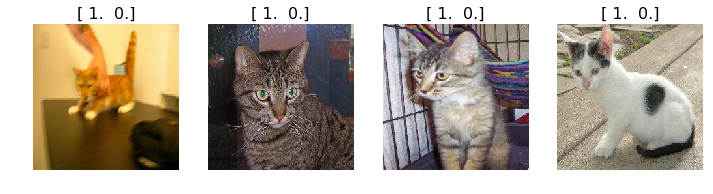

In [60]:
images, labels = next(train_batches)
plots(images, titles=labels)

In [61]:
model, classes = finetune(model, train_batches)
type(model)

keras.models.Sequential

In [62]:
model = fit(model, train_batches, val_batches, nb_epoch=1)

Epoch 1/1
12/12 [==============================] - 5s - loss: 0.4391 - acc: 0.9167 - val_loss: 0.2200 - val_acc: 0.7500


In [63]:
type(model)

keras.models.Sequential

In [64]:
test_batches = get_batches('test', batch_size= 4)
test_images, test_labels = next(test_batches)
test_batches.nb_sample

Found 6 images belonging to 2 classes.


6

In [65]:
# type(test_batches)
ite = (test_batches)
type(ite)

keras.preprocessing.image.DirectoryIterator

In [68]:
model.predict_generator(test_batches, test_batches.nb_sample)

array([[ 0.1794,  0.8206],
       [ 0.6453,  0.3547],
       [ 0.9969,  0.0031],
       [ 0.8752,  0.1248],
       [ 0.9927,  0.0073],
       [ 0.917 ,  0.083 ]], dtype=float32)

In [67]:
pred_batch(model, test_images)

Shape: (4, 2)
First 5 classes: ['cats', 'dogs']
First 5 probabilities: [[ 0.9969  0.0031]
 [ 0.8752  0.1248]
 [ 0.9927  0.0073]
 [ 0.917   0.083 ]]

Predictions prob/class: 
  0.9969/cats
  0.8752/cats
  0.9927/cats
  0.9170/cats


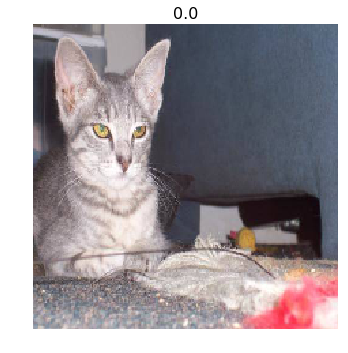

In [33]:
plots(np.reshape(test_images[2], (1,3,224,224)), titles=test_labels[0])